In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os,cmocean
import scipy.io as sio
from scipy import interpolate
from pyproj import Proj,transform
from bathy_common import *
from matplotlib import path

In [2]:
# Load bathy, and the t and f grid
mpath = '/home/mdunphy/NEMO_PREPARATION/1_Seagrid_generator/cascdem/hhh.mat'
mfile = sio.loadmat(mpath)
bathyjpi = mfile['h_wet2']  # JP's nearest interpolation (before removing lakes,etc)
bathyjpi[np.isnan(bathyjpi)]=0

jppath='/ocean/dlatorne/MEOPAR/NEMO/WC3_PREP/2_bathy'
bnc = nc.Dataset(os.path.join(jppath, 'bathy_meter_min4.nc'), 'r')
bathyjp = bnc.variables['Bathymetry'][:]; bnc.close()
bathyjp = bathyjp.filled(0)

sspath='/home/mdunphy/MEOPAR/NEMO-forcing/grid'
bnc = nc.Dataset(os.path.join(sspath, 'bathy_downonegrid2.nc'), 'r')
bathyd1 = bnc.variables['Bathymetry'][:]; bnc.close()

bnc = nc.Dataset(os.path.join(sspath, 'bathy_meter_SalishSea6.nc'), 'r')
bathy6 = bnc.variables['Bathymetry'][:]; bnc.close()

bathyd1, bathy6 = bathyd1.filled(0), bathy6.filled(0)

cnc = nc.Dataset(os.path.join(sspath, 'coordinates_seagrid_SalishSea.nc'), 'r')
glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
cnc.close()
NY, NX = glamt.shape[0], glamt.shape[1]
glamfe, gphife = expandf(glamf, gphif)

In [3]:
chsfile="/home/mdunphy/MEOPAR/ZOOM/chs/Salish Sea 25m Grid.txt"
def getchs(filename):
    # Load CHS data, cache in a .npz file for faster loading
    cache=filename+".npz"
    if os.path.exists(cache):
        npzfile = np.load(cache)
        x, y, z = npzfile['x'], npzfile['y'], npzfile['z']
    else:
        a = np.loadtxt(filename, delimiter=',')
        x, y, z = np.float32(a[:,0]), np.float32(a[:,1]), a[:,2]
        np.savez(cache, x=x, y=y, z=z)
    p = Proj("+proj=utm +zone=10U")    # UTM to lon, lat using zone 10U
    return x,y,z,p

In [ ]:
cascadiafile = '/home/mdunphy/MEOPAR/ZOOM/chs/USGS/cascadia.bil'
def getcascadia(filename):
    # Adapted from: https://pymorton.wordpress.com/2016/02/26/plotting-prism-bil-arrays-without-using-gdal/
    def read_prism_hdr(hdr_path):
        """Read an ESRI BIL HDR file"""
        with open(hdr_path, 'r') as input_f:
            header_list = input_f.readlines()
        return dict(item.strip().split() for item in header_list)
    def read_prism_bil(bil_path):
        """Read an array from ESRI BIL raster file"""
        hdr_dict = read_prism_hdr(bil_path.replace('.bil', '.hdr'))
        data = np.fromfile(bil_path, dtype=np.int16).byteswap()
        data = data.reshape(int(hdr_dict['NROWS']), int(hdr_dict['NCOLS']))
        return data
    z = np.flipud(read_prism_bil(filename))    # load data
    mask = (z == 0) | (z >= 10000)             # mask for nonexistant points and land points
    z -= 10000                                 # remove offset
    z *= -1                                    # make depths positive
    z[mask] = 0                                # set masked values to zero
    zm = ma.masked_array(z, mask=mask)
    # Construct Cascadia coordinates
    xmin, xmax, dx = -738044.062, 749705.938, 250
    ymin, ymax, dy = 101590.289, 1710340.289, 250
    x=xmin + dx*np.arange(0, z.shape[1]) + dx/2
    y=ymin + dy*np.arange(0, z.shape[0]) + dy/2
    p = Proj(r'+proj=lcc +lat_1=41.5 +lat_2=50.5 +lat_0=38 +lon_0=-124.5 +x_0=0 +y_0=0 +ellps=clrk66 +no_defs')
    return x,y,z,p

<IPython.core.display.Javascript object>


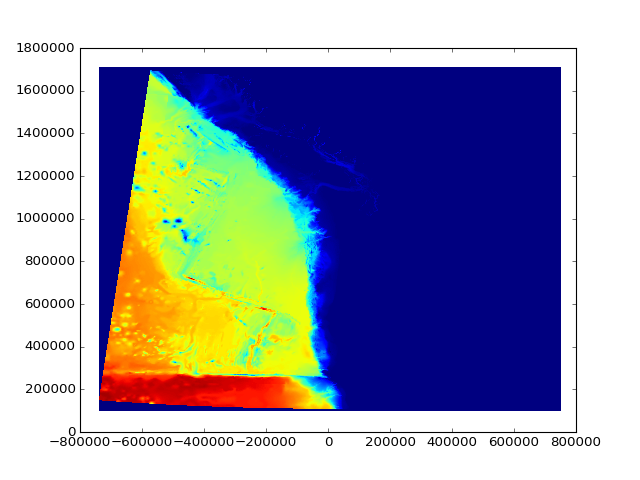

In [6]:
    x,y,z,p = getcascadia(cascadiafile)
plt.figure()
plt.pcolormesh(x,y,z)



In [5]:
cache=cascadiafile+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with Cascadia data
    x,y,z,p = getcascadia(cascadiafile)

    # Convert NEMO coords to Cascadia projected coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(Xfe)) & (x <= np.max(Xfe))
    idx2 = (y >= np.min(Yfe)) & (y <= np.max(Yfe))
    x,y = x[idx1], y[idx2]
    z = z[idx2,:]
    z = z[:,idx1]
    X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X,Y,z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(makebox(Xfe,Yfe,0,NX,0,NY), closed=True)
    tmp = np.zeros([X.size,2]); tmp[:,0]=X; tmp[:,1]=Y;
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X,Y)
    xi = (Xt.flatten(), Yt.flatten())
    casnearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    caslinear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), Xt.shape)

    Xo,Yo = X-125,Y-125
    points = (Xo,Yo)
    casnearestjp = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    
    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(Xfe,Yfe,X,Y,cache=cascadiafile+".boxij.npz",searchmore=False)
    casmin,casmax,casmean,casmedian,cascount = binstobathy(boxi,boxj,X,Y,z,NX,NY)

    np.savez(cache, casmin=casmin, casmax=casmax, casmean=casmean, casmedian=casmedian,
                    cascount=cascount, casnearest=casnearest, caslinear=caslinear, casnearestjp=casnearestjp)
#1239279 points in 407.3525502681732 s
#hit0 report: 466518/1239279=37.644307698266495%
#hit1 report: 768443/1239279=62.00726390102632%
#hit2 report: 0/1239279=0.0%
#hit3 report: 0/1239279=0.0%
#hit4 report: 0/1239279=0.0%
#no hit report: 4318/1239279=0.3484284007071854%
#points not in domain: 0

In [6]:
cache=chsfile+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with CHS data
    x,y,z,p=getchs(chsfile)

    # Convert NEMO coords to CHS projected coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # Construct new bathy using interpolation
    points = (x,y)
    xi = (Xt.flatten(), Yt.flatten())
    chsnearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    chslinear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), Xt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(Xfe,Yfe,x,y,cache=chsfile+".boxij.npz",searchmore=True)
    chsmin,chsmax,chsmean,chsmedian,chscount = binstobathy(boxi,boxj,x,y,z,NX,NY)
    cache=chsfile+".results.npz"
    np.savez(cache, chsmin=chsmin, chsmax=chsmax, chsmean=chsmean, chsmedian=chsmedian,
                    chscount=chscount, chsnearest=chsnearest, chslinear=chslinear)

<IPython.core.display.Javascript object>


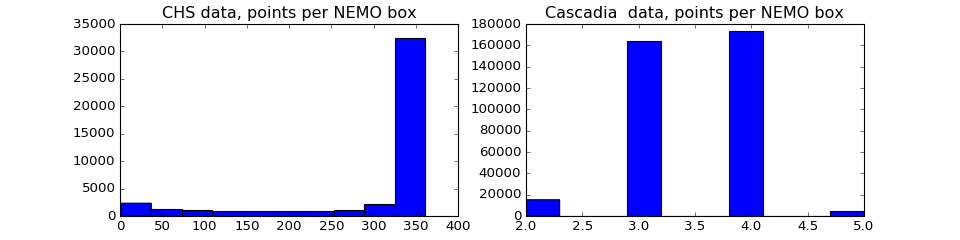

In [76]:
def dezero(x): return x.flatten()[x.flatten()>0]
plt.figure(figsize=(12,3)); plt.clf();
plt.subplot(1,2,1); plt.hist(dezero(chscount)); plt.title('CHS data, points per NEMO box')
plt.subplot(1,2,2); plt.hist(dezero(cascount)); plt.title('Cascadia  data, points per NEMO box')

In [77]:
# Plotting helper funtion
def mm(x):
    return ma.masked_array(x, mask=(x == 0 | np.isnan(x)))
chsmask, casmask, b6mask, spmask = mm(chsmin), mm(casmin), mm(bathy6), mm(bathy6+bathyjpi)
def cmp(a,b,c,d,e):  # compare a and b, mask from c, colorbar limits d, title e
    im=plt.pcolormesh(c*0 + a -b); cb=plt.colorbar(im);
    im.set_cmap('seismic'); im.set_clim([-d,d]); cb.set_clim(-d,d); plt.title(e)


<IPython.core.display.Javascript object>


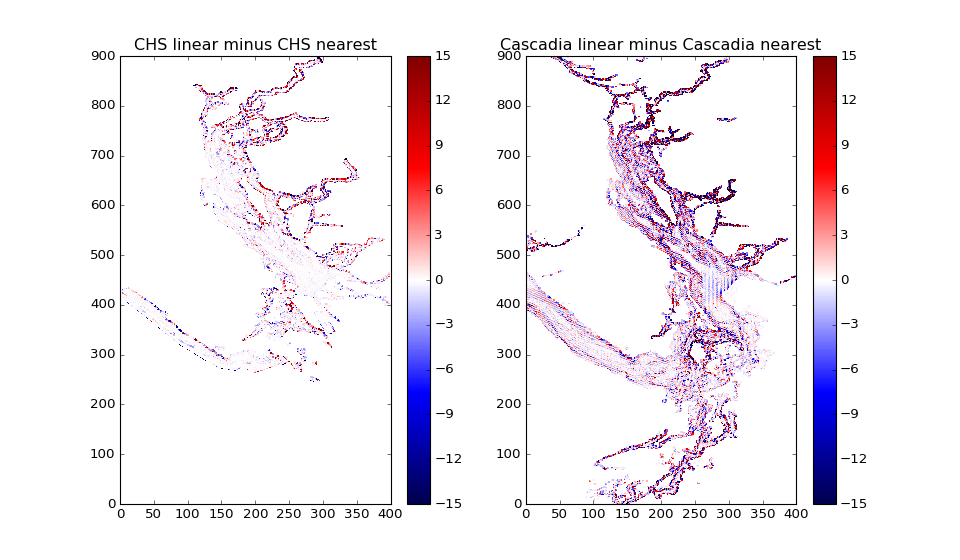

In [79]:
plt.figure(figsize=(12,7)); plt.clf();
plt.subplot(1,2,1); cmp(chslinear,chsnearest,chsmask,15,'CHS linear minus CHS nearest')
plt.subplot(1,2,2); cmp(caslinear,casnearest,casmask,15,'Cascadia linear minus Cascadia nearest')
# Right: expect to be similar in most regions
# Left: +/- noise for linear vs staircase

<IPython.core.display.Javascript object>


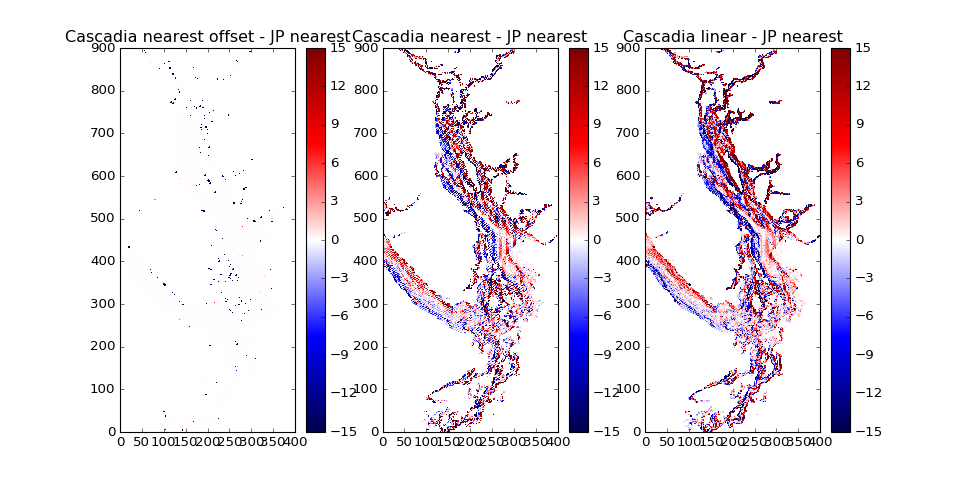

In [26]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); cmp(casnearestjp,bathyjpi, casmask,15,'Cascadia nearest offset - JP nearest')
plt.subplot(1,3,2); cmp(casnearest, bathyjpi, casmask,15,'Cascadia nearest - JP nearest')
plt.subplot(1,3,3); cmp(caslinear,  bathyjpi, casmask,15,'Cascadia linear - JP nearest')
# Left: Reproduced JP's initial nearest interp by adding the offset back
# Middle: Compare with and without offset, both nearest
# Right: Compare with and without offset, linear cascadia and nearest JP

<IPython.core.display.Javascript object>


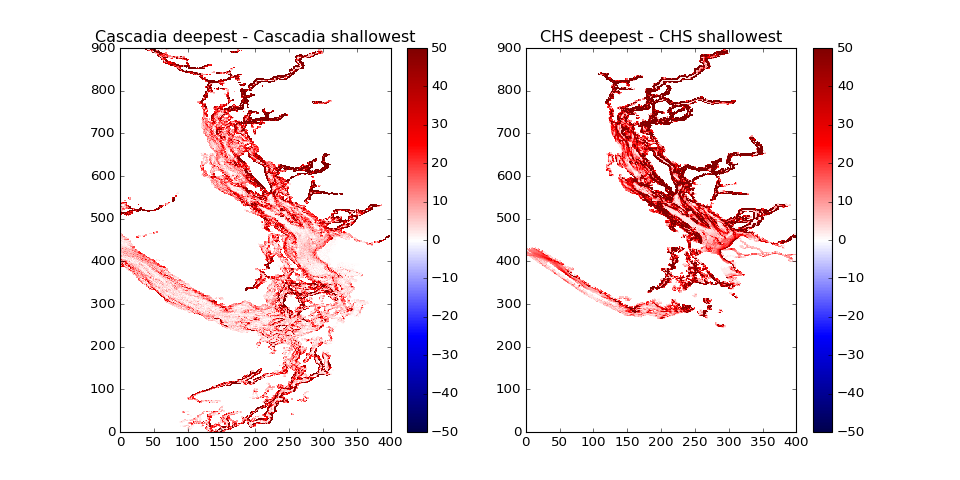

In [169]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,2,1); cmp(casmax,casmin,casmask,50,'Cascadia deepest - Cascadia shallowest')
plt.subplot(1,2,2); cmp(chsmax,chsmin,chsmask,50,'CHS deepest - CHS shallowest')
# Shows the range in each grid box

<IPython.core.display.Javascript object>


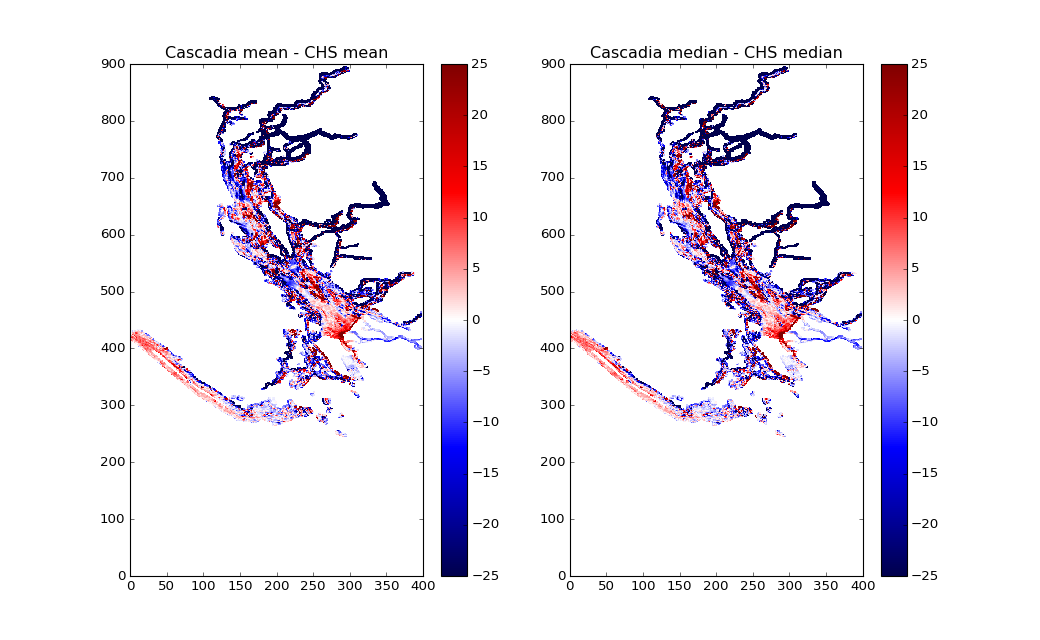

In [216]:
plt.figure(figsize=(13,8)); plt.clf();
plt.subplot(1,2,1); cmp(casmean, chsmean, chsmask, 25, 'Cascadia mean - CHS mean')
plt.subplot(1,2,2); cmp(casmedian, chsmedian, chsmask, 25, 'Cascadia median - CHS median')


<IPython.core.display.Javascript object>


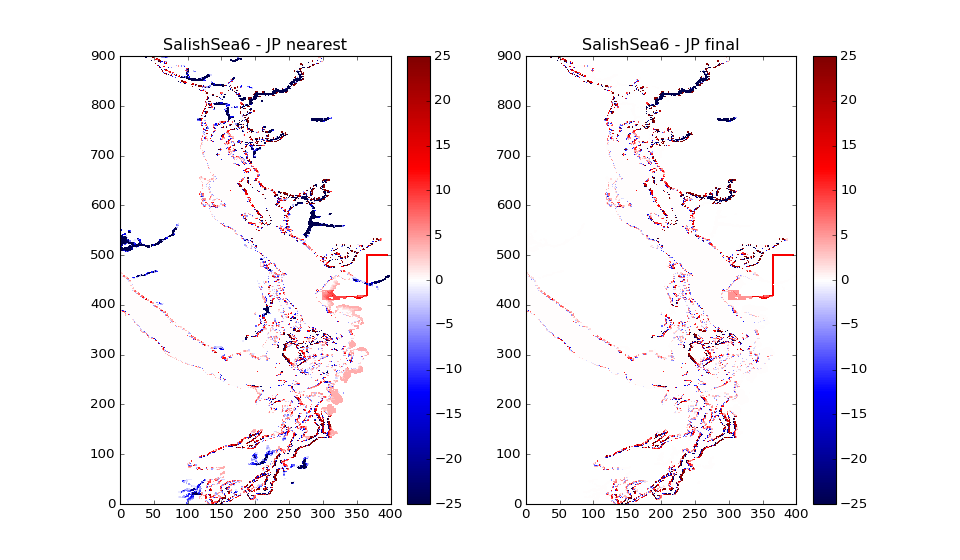

In [203]:
plt.figure(figsize=(12,7)); plt.clf();
plt.subplot(1,2,1); cmp(bathy6, bathyjpi, mm(bathyjpi+bathy6),25,'SalishSea6 - JP nearest')
plt.subplot(1,2,2); cmp(bathy6, bathyjp, mm(bathyjpi+bathy6),25,'SalishSea6 - JP final')
# Left; Should be a map of all the adjustments following the initial nearest interp from JP
# 

In [222]:
bathymd=np.zeros(bathy6.shape)
for j in range(bathy6.shape[0]):
    for i in range(bathy6.shape[1]):
        chsb = chsmean[j,i].astype(np.float64)
        casb = casmean[j,i].astype(np.float64)
        if chsb > 0 and casb == 0: bathymd[j,i]=chsb
        if casb > 0 and chsb == 0: bathymd[j,i]=casb
        if casb > 0 and chsb > 0: bathymd[j,i]=0.5*casb+0.5*chsb

#idx=bathymd>0; bathymd[idx] = bathymd[idx]+3        # add 3m datum everywhere
bathymd[bathymd>428]=428                            # clip depth to 428m
idx = (bathymd>0) & (bathymd < 4); bathymd[idx]=4   # minimum 4m depth

diff=bathymd-bathy6
print(np.mean(diff[bathy6>50]))

bathyjp2=bathyjp;bathyjp2[bathyjp2>428]=428;
diff=bathymd-bathyjp2
print(np.mean(diff[bathy6>50]))


2.00381833759
1.44491476061


<IPython.core.display.Javascript object>


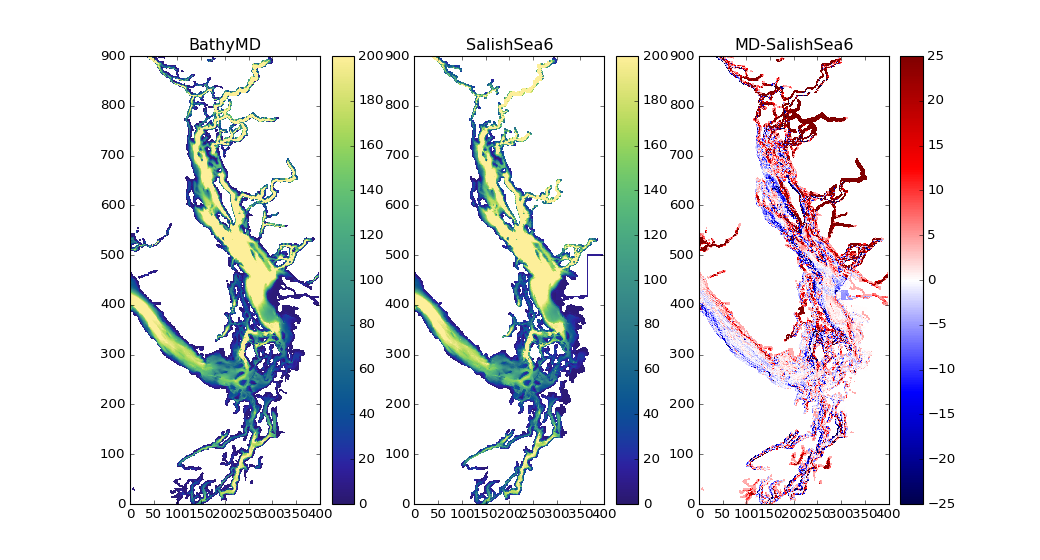

In [223]:
def shw(a,b,c,d):  # plot a, mask b, colorbar limits c, title d
    if b is None: b=mm(a)
    im=plt.pcolormesh(b*0+a); cb=plt.colorbar(im);
    im.set_cmap(cmocean.cm.haline); im.set_clim([0,c]); cb.set_clim(0,c); plt.title(d)
plt.figure(figsize=(13,7)); plt.clf();
plt.subplot(1,3,1); shw(bathymd, None, 200, 'BathyMD')
plt.subplot(1,3,2); shw(bathy6, None, 200, 'SalishSea6')
plt.subplot(1,3,3); cmp(bathymd,bathy6, mm(bathymd), 25, 'MD-SalishSea6')

<IPython.core.display.Javascript object>


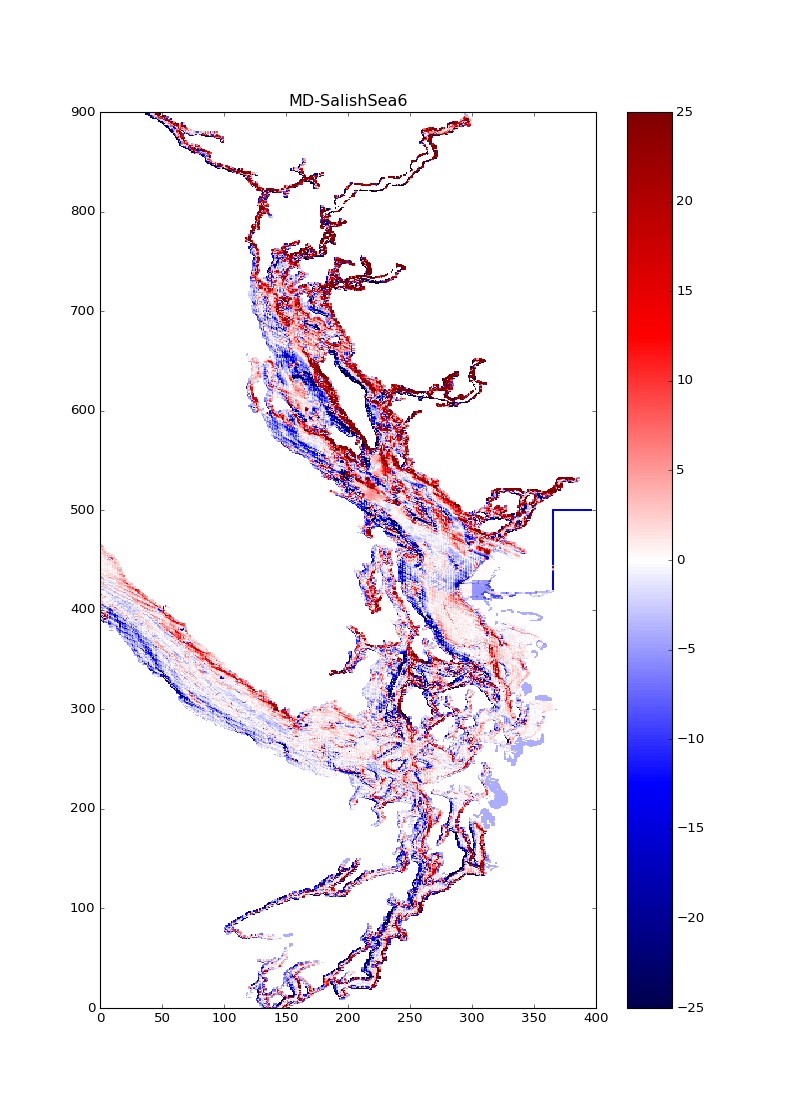

In [224]:
plt.figure(figsize=(10,14)); plt.clf();
cmp(bathymd, bathy6, mm(bathy6), 25, 'MD-SalishSea6')

<IPython.core.display.Javascript object>


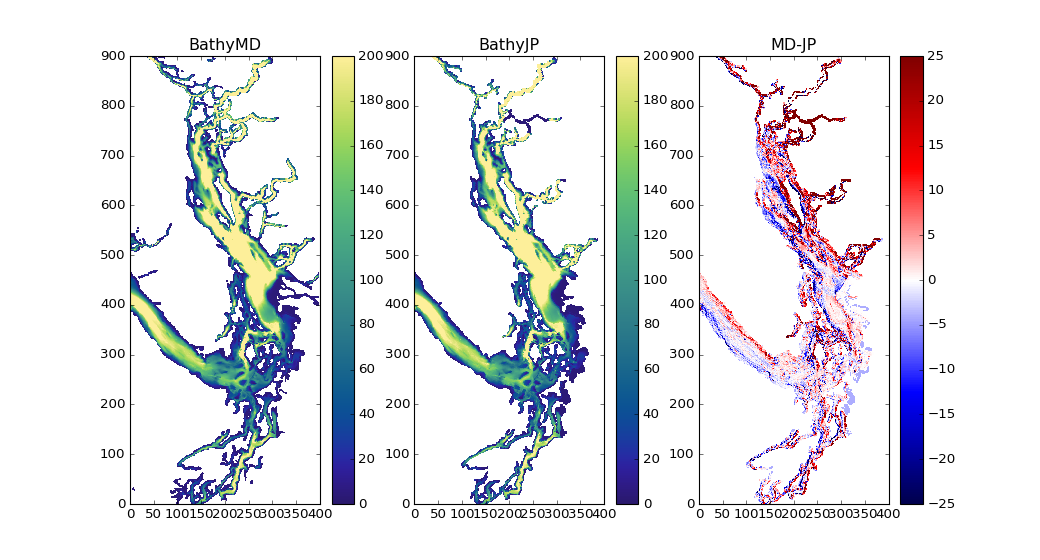

In [225]:
plt.figure(figsize=(13,7)); plt.clf();
plt.subplot(1,3,1); shw(bathymd, None, 200, 'BathyMD')
plt.subplot(1,3,2); shw(bathyjp2, None, 200, 'BathyJP')
plt.subplot(1,3,3); cmp(bathymd,bathyjp2, mm(bathyjp2), 25, 'MD-JP')


<IPython.core.display.Javascript object>


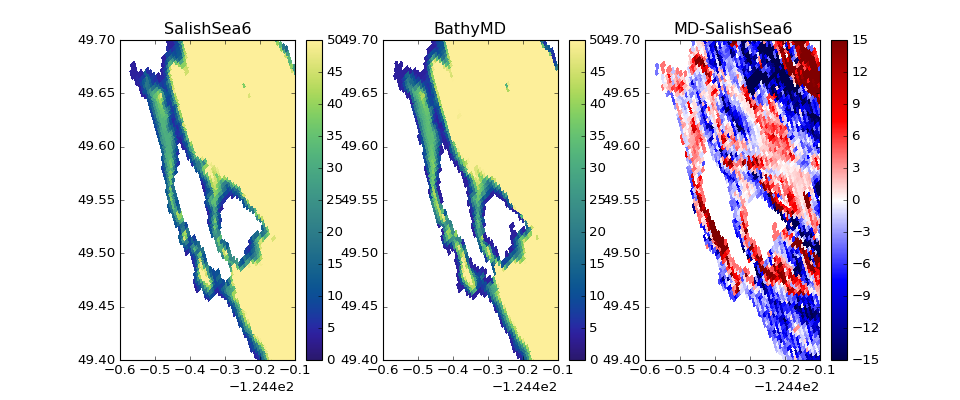

In [227]:
# Zoom on Baynes Sound
def lims():
    plt.gca().set_ylim([49.4,49.7])
    plt.gca().set_xlim([-125,-124.5])

plt.figure(3,figsize=(12,5)); plt.clf()
plt.subplot(1,3,1);
im=plt.pcolormesh(glamt,gphit,mm(bathy6)); cb=plt.colorbar(im);
im.set_clim(0,200); cb.set_clim(0,50); im.set_cmap(cmocean.cm.haline);
lims()
plt.title("SalishSea6")

plt.subplot(1,3,2);
im=plt.pcolormesh(glamt,gphit,mm(bathymd)); cb=plt.colorbar(im)
im.set_clim(0,200); cb.set_clim(0,50); im.set_cmap(cmocean.cm.haline);
lims()
plt.title("BathyMD")

plt.subplot(1,3,3);
im=plt.pcolormesh(glamt,gphit,mm(bathymd-bathy6));  cb=plt.colorbar(im)
im.set_clim(0,200); cb.set_clim(-15,15); im.set_cmap('seismic');
lims()
plt.title("MD-SalishSea6")